In [1]:
import numpy as np
import torch
from torch.distributions import Normal, Uniform
from torch.distributions.multivariate_normal import MultivariateNormal
from functools import partial
import matplotlib.pyplot as plt

In [2]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def eigsorted(cov):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:,order]

def plot_cov_ellipse(cov, 
                     pos, 
                     nstd = 1, 
                     label = '1 std confidence ellipse', 
                     color = 'r',
                     fill = False,
                     **kwargs):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the 
    ellipse patch artist.

    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy = pos, 
                    width = width, 
                    height = height, 
                    angle = theta, 
                    color = color,
                    label = label,
                    fill = fill, **kwargs)

    return ellip

In [3]:
def U_quadratic_1d(q, *args):
    return (q @ q)/2

def U_quadratic_2d(q, *args):
    Sigma_inv = args
    if len(Sigma_inv) == 0:
        Sigma_inv = torch.eye(q.shape[0], 
                              device = q.device,
                              dtype = q.dtype)
    else:
        Sigma_inv = Sigma_inv[0]
    return q.T @ (Sigma_inv @ q)/2

def grad_U(q, U, device = "cuda:0", *args):
    U_in_q = U(q, *args)
    #print(U_in_q)
    U_in_q.backward()
    grad_U_in_q = q.grad.to(device)
    return grad_U_in_q

def partial_grad_U(grad_U, U):
    return partial(grad_U, U = U)

def make_step(grad_U, 
              q, p, 
              epsilon,
              method = "leapfrog",
              device = "cuda:0",
              *args):
    if method == "simple Euler's":
        new_p = (p - epsilon*grad_U(q = q, 
                                   device = device,
                                   *args)).detach().clone().requires_grad_()
        new_q = (q + epsilon*p).detach().clone().requires_grad_()
        
    elif method == "modifying Euler's":
        new_p = (p - epsilon*grad_U(q = q, 
                                   device = device,
                                   *args)).detach().clone().requires_grad_()
        new_q = (q + epsilon*new_p).detach().clone().requires_grad_()
        
    elif method == "leapfrog":
        p_half_step = p - epsilon/2*grad_U(q = q, 
                                           device = device,
                                           *args)
        new_q = (q + epsilon*p_half_step).detach().clone().requires_grad_()
        new_p = (p_half_step - epsilon/2*grad_U(q = new_q, 
                                               device = device,
                                               *args)).detach().clone().requires_grad_()
        
    else:
        raise ValueError(f"Only simple Euler's, modifying Euler's and leapfrog methods are available")
        
    return new_q, new_p

def Hamiltonian_dynamics(grad_U, start_q, start_p, 
                         epsilon, warmup_steps,
                         method = "leapfrog",
                         device = "cuda:0",  
                         *args):
    q_dynamics_shape = (warmup_steps + 1, ) + tuple(start_q.shape)
    q_dynamics = torch.zeros(q_dynamics_shape, 
                             dtype = start_q.dtype).to(device)
    p_dynamics = torch.zeros(q_dynamics_shape, 
                             dtype = start_p.dtype).to(device)
    start_q_clone = start_q.detach().clone()
    start_p_clone = start_p.detach().clone()
    q_dynamics[0, :] = start_q_clone
    p_dynamics[0, :] = start_p_clone
    for i in range(warmup_steps):
        cur_q = q_dynamics[i, :].detach().clone().requires_grad_()
        cur_p = p_dynamics[i, :].detach().clone().requires_grad_()
        q_dynamics[i + 1, :], p_dynamics[i + 1, :] = make_step(grad_U = grad_U,
                                                               q = cur_q, 
                                                               p = cur_p,
                                                               epsilon = epsilon,
                                                               method = method, 
                                                               device = device,
                                                               *args)
    return q_dynamics, p_dynamics



def Hamiltonian_MC_dynamics_step(U, grad_U, epsilon, 
                                 warmup_steps, current_q,
                                 current_p = None,
                                 device = "cuda:0", 
                                 return_trajectory = False,
                                 *args):
    q = current_q.clone().detach().to(device).requires_grad_()
    
    if current_p is None:
        p = torch.normal(0., 1., size = current_q.shape).to(device) #independent standard normal variates
        current_p = p.clone().detach().to(device)
    else:
        p = current_p.clone().detach().to(device).requires_grad_()
    
    if return_trajectory:
        q_dynamics_shape = (warmup_steps + 1, ) + tuple(current_q.shape)
        q_dynamics = torch.zeros(q_dynamics_shape, 
                             dtype = q.dtype).to(device)
        p_dynamics = torch.zeros(q_dynamics_shape, 
                             dtype = p.dtype).to(device)
        q_dynamics[0, :] = q.clone()
        p_dynamics[0, :] = p.clone()
    
    #Make a half step for momentum at the beginning
    p = p - (epsilon/2)*grad_U(q, U, device, *args)
    
    #Alternate full steps for position and momentum
    for i in range(warmup_steps):
        
        #Make a full step for the momentum, except at end of trajectory
        q = q + epsilon*p
            
        if i != warmup_steps:
            cur_q = q.detach().clone().requires_grad_()
            if return_trajectory:
                q_dynamics[i + 1, :] = cur_q
                p_dynamics[i + 1, :] = (p - (epsilon/2)*grad_U(cur_q, 
                                                               U,
                                                               device, 
                                                               *args)).detach().clone().requires_grad_()
            p = p - epsilon*grad_U(cur_q, U, device, *args)
    
    #Make a half step for momentum at the end
    cur_q = q.detach().clone().requires_grad_()
    p = p - (epsilon/2)*grad_U(cur_q, U, device, *args)
    if return_trajectory:
        p_dynamics[-1, :] = p.detach().clone().requires_grad_()
    
    #Negate momentum at the end of trajectory to make the proposal symmetric
    p *= -1
    
    #Evaluate potential and kinetic energies at start and end of trajectory
    current_U = U(current_q, *args)
    current_K = (current_p @ current_p)/2
    proposed_U = U(q, *args)
    proposed_K = (p @ p)/2
    
    #Accept or reject the state at end of trajectory, returning either
    #the position at the end of the trajectory or the initial position
    
    uniform_sampler = Uniform(low = 0, high = 1)
    generate_uniform_var = uniform_sampler.sample().to(device)
    if generate_uniform_var < torch.exp(current_U - proposed_U + current_K - proposed_K):
        if return_trajectory:
            return q, q_dynamics, p_dynamics
        else:
            return q
    else:
        if return_trajectory:
            return current_q, q_dynamics, p_dynamics
        else:
            return current_q
        
def Hamiltonian_MC_dynamics(U, grad_U, 
                            num_iterations,
                            epsilon, 
                            warmup_steps, 
                            start_q,
                            device = "cuda:0",
                            count_rejections = False,
                            return_unique_num = False,
                            *args):
    
    cur_q = start_q.clone().detach().to(device).requires_grad_()
    trajectory_q = [start_q]
    num_unique = 1
    for i in range(num_iterations):
        new_q = Hamiltonian_MC_dynamics_step(U, grad_U, 
                                             epsilon, 
                                             warmup_steps, 
                                             cur_q,
                                             None,
                                             device,
                                             False,
                                             *args)
        if (new_q - cur_q).norm(p = 2) > 1e-10:
            trajectory_q.append(new_q)
            cur_q = new_q.clone().detach().to(device).requires_grad_()
            num_unique += 1
        
        elif count_rejections:
            trajectory_q.append(cur_q)
    
    if return_unique_num:
        return torch.stack(trajectory_q, dim = 0), num_unique
    
    else:
        return torch.stack(trajectory_q, dim = 0)
    
def Hamiltonian_MC_dynamics_uniform_epsilon(U, grad_U, 
                                            num_iterations,
                                            low_epsilon,
                                            high_epsilon,
                                            warmup_steps, 
                                            start_q,
                                            device = "cuda:0",
                                            count_rejections = False,
                                            return_unique_num = False,
                                            *args):
    uniform_sampler = Uniform(low = low_epsilon, high = high_epsilon)
    cur_q = start_q.clone().detach().to(device).requires_grad_()
    trajectory_q = [start_q]
    num_unique = 1
    for i in range(num_iterations):
        generate_uniform_epsilon = uniform_sampler.sample().to(device)
        new_q = Hamiltonian_MC_dynamics_step(U, grad_U, 
                                             generate_uniform_epsilon, 
                                             warmup_steps, 
                                             cur_q,
                                             None,
                                             device,
                                             False,
                                             *args)
        if (new_q - cur_q).norm(p = 2) > 1e-10:
            trajectory_q.append(new_q)
            cur_q = new_q.clone().detach().to(device).requires_grad_()
            num_unique += 1
        
        elif count_rejections:
            trajectory_q.append(cur_q)
    
    if return_unique_num:
        return torch.stack(trajectory_q, dim = 0), num_unique
    
    else:
        return torch.stack(trajectory_q, dim = 0)

def Metropolis_algo_with_Gaussian_proposal(num_iterations, 
                                           start_q, 
                                           cov_proposal, 
                                           target_distribution, 
                                           device = "cuda:0",
                                           return_unique_num = False):
    uniform_sampler = Uniform(low = 0, high = 1)
    trajectory_q = [start_q]
    num_unique = 1
    for i in range(num_iterations):
        cur_q = trajectory_q[i].clone().detach().to(device)
        Gaussian_sampler = MultivariateNormal(loc = cur_q, covariance_matrix = cov_proposal)
        propose_q = Gaussian_sampler.sample().to(device)
        target_log_prob_in_propose = target_distribution.log_prob(propose_q)
        target_log_prob_in_cur = target_distribution.log_prob(cur_q)
        generate_uniform_var = uniform_sampler.sample().to(device)
        log_generate_uniform_var = torch.log(generate_uniform_var)
        if log_generate_uniform_var + target_log_prob_in_cur < target_log_prob_in_propose:
            trajectory_q.append(propose_q)
            num_unique += 1
        else:
            trajectory_q.append(cur_q)
            
    if return_unique_num:
        return torch.stack(trajectory_q, dim = 0), num_unique
    
    else:
        return torch.stack(trajectory_q, dim = 0)
    
def Metropolis_algo_with_Gaussian_proposal_uniform_stds(num_iterations, 
                                                        start_q, 
                                                        low_std,
                                                        high_std,
                                                        target_distribution, 
                                                        device = "cuda:0",
                                                        return_unique_num = False):
    trajectory_q = [start_q]
    num_unique = 1
    uniform_sampler = Uniform(low = 0, high = 1)
    uniform_stds_sampler = Uniform(low = low_std, high = high_std)
    for i in range(num_iterations):
        cur_q = trajectory_q[i].clone().detach().to(device)
        cur_std = uniform_stds_sampler.sample().to(device)
        cov_proposal = (torch.pow(cur_std, 2) * torch.eye(start_q.shape[0], 
                                                          dtype = torch.float64)).to(device)
        Gaussian_sampler = MultivariateNormal(loc = cur_q, covariance_matrix = cov_proposal)
        propose_q = Gaussian_sampler.sample().to(device)
        target_log_prob_in_propose = target_distribution.log_prob(propose_q)
        target_log_prob_in_cur = target_distribution.log_prob(cur_q)
        generate_uniform_var = uniform_sampler.sample().to(device)
        log_generate_uniform_var = torch.log(generate_uniform_var)
        if log_generate_uniform_var + target_log_prob_in_cur < target_log_prob_in_propose:
            trajectory_q.append(propose_q)
            num_unique += 1
        else:
            trajectory_q.append(cur_q)
            
    if return_unique_num:
        return torch.stack(trajectory_q, dim = 0), num_unique
    
    else:
        return torch.stack(trajectory_q, dim = 0)

## Testing automatic differentiation in PyTorch 

In [4]:
device = "cuda:0"
q0_2d = torch.tensor([-1.50, -1.55], 
                  dtype = torch.float64, 
                  device = device,
                  requires_grad = True)

Sigma = torch.tensor([[1, 0.95], [0.95, 1]], 
                     dtype = torch.float64,
                     device = device)
Sigma_inv = torch.inverse(Sigma)

U_in_q0_2d = U_quadratic_2d(q0_2d, Sigma_inv)
grad_U_in_q0_2d = grad_U(q0_2d, 
                         U_quadratic_2d,
                         device, 
                         Sigma_inv)
q0_2d_print = q0_2d.detach().cpu().numpy()
U_in_q0_2d_print = U_in_q0_2d.detach().cpu().item()
grad_U_in_q0_2d_print = grad_U_in_q0_2d.detach().cpu().numpy()
print(f"q0 2d = {q0_2d_print}, U in q0 2d = {U_in_q0_2d_print}, grad U in q0 2d = {grad_U_in_q0_2d_print}")
q0_1d = torch.tensor([7.0], 
                  dtype = torch.float64, 
                  device = device,
                  requires_grad = True)
U_in_q0_1d = U_quadratic_1d(q0_1d)
grad_U_1d = partial_grad_U(grad_U, U_quadratic_1d)
grad_U_in_q0_1d = grad_U_1d(q = q0_1d, 
                            device = device)
q0_1d_print = q0_1d.detach().cpu().numpy()
U_in_q0_1d_print = U_in_q0_1d.detach().cpu().item()
grad_U_in_q0_1d_print = grad_U_in_q0_1d.detach().cpu().numpy()
print(f"q0 1d = {q0_1d_print}, U in q0 1d = {U_in_q0_1d_print}, grad U in q0 1d = {grad_U_in_q0_1d_print}")

q0 2d = [-1.5  -1.55], U in q0 2d = 1.2051282051282044, grad U in q0 2d = [-0.28205128 -1.28205128]
q0 1d = [7.], U in q0 1d = 24.5, grad U in q0 1d = [7.]


## Testing Hamiltonian dynamics for different methods

In [5]:
q0_1d = torch.tensor([0.0], 
                  dtype = torch.float64, 
                  device = device,
                  requires_grad = True)
p0_1d = torch.tensor([1.0], 
                  dtype = torch.float64, 
                  device = device,
                  requires_grad = True)
epsilon = 0.3
method = "leapfrog"
q1_1d, p1_1d = make_step(grad_U = grad_U_1d, 
                         q = q0_1d, 
                         p = p0_1d, 
                         epsilon = epsilon,
                         method = method,
                         device = device)
print(f"After 1 {method} step new values for q, p = {q1_1d.item():.4f}, {p1_1d.item():.4f}")
method = "simple Euler's"
q2_1d, p2_1d = make_step(grad_U = grad_U_1d, 
                         q = q1_1d, 
                         p = p1_1d, 
                         epsilon = epsilon,
                         method = method,
                         device = device)
print(f"After 1 {method} step new values for q, p = {q2_1d.item():.4f}, {p2_1d.item():.4f}")
method = "modifying Euler's"
q3_1d, p3_1d = make_step(grad_U = grad_U_1d, 
                         q = q2_1d, 
                         p = p2_1d, 
                         epsilon = epsilon,
                         method = method,
                         device = device)
print(f"After 1 {method} step new values for q, p = {q3_1d.item():.4f}, {p3_1d.item():.4f}")

After 1 leapfrog step new values for q, p = 0.3000, 0.9550
After 1 simple Euler's step new values for q, p = 0.5865, 0.7750
After 1 modifying Euler's step new values for q, p = 0.7662, 0.5990


## Plotting Hamiltonian dynamics

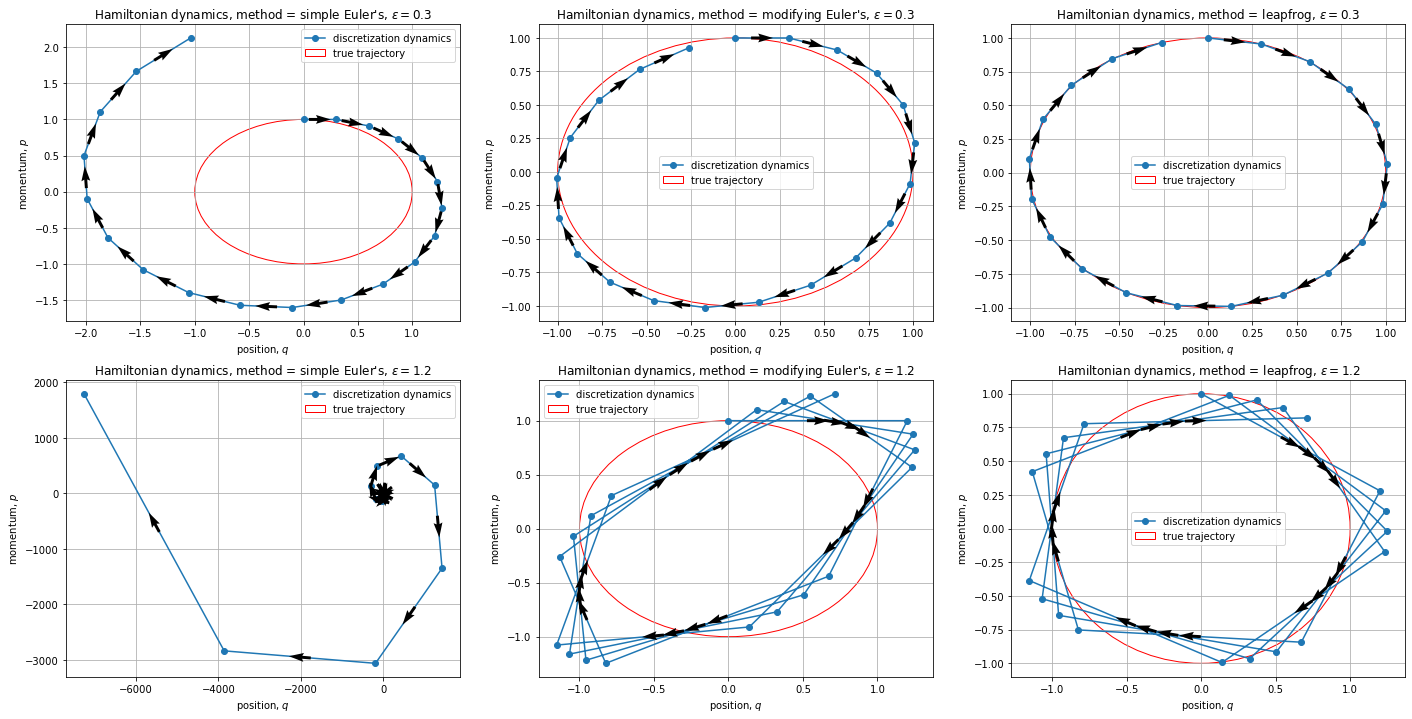

In [6]:
figsize = (24, 12)
q0_1d = torch.tensor([0.0], 
                  dtype = torch.float64, 
                  device = device,
                  requires_grad = True)
p0_1d = torch.tensor([1.0], 
                  dtype = torch.float64, 
                  device = device,
                  requires_grad = True)
methods = ["simple Euler's", "modifying Euler's", "leapfrog"]
epsilons = [0.3, 1.2]
warmup_steps = 20
num_methods = len(methods)
num_epsilons = len(epsilons)
num_plots = num_methods*num_epsilons
fig = plt.figure(figsize = figsize)
cur_index = 0
for epsilon in epsilons:
    for method in methods:
        q_dynamics, p_dynamics = Hamiltonian_dynamics(grad_U = grad_U_1d, 
                                                      start_q = q0_1d, 
                                                      start_p = p0_1d, 
                                                      epsilon = epsilon, 
                                                      warmup_steps = warmup_steps,
                                                      method = method,
                                                      device = device)
        q_dynamics_plot, p_dynamics_plot = (q_dynamics.detach().cpu().numpy()[:, 0], 
                                            p_dynamics.detach().cpu().numpy()[:, 0])
        u = np.diff(q_dynamics_plot)
        v = np.diff(p_dynamics_plot)
        pos_q = q_dynamics_plot[:-1] + u/2
        pos_p = p_dynamics_plot[:-1] + v/2
        norm = np.sqrt(u**2+v**2) 

        cur_plot = plt.subplot(num_epsilons, num_methods, cur_index + 1)
        cur_plot.set_xlabel(r'position, $q$')
        cur_plot.set_ylabel(r'momentum, $p$')
        cur_plot.plot(q_dynamics_plot, p_dynamics_plot, label = 'discretization dynamics', marker="o")
        cur_plot.quiver(pos_q, pos_p, u/norm, v/norm, angles="xy", zorder=5, pivot="mid")
        circle = plt.Circle((0, 0), 1, color = 'r', fill = False, label = "true trajectory")           
        cur_plot.add_patch(circle)
        cur_plot.set_title(fr"Hamiltonian dynamics, method = {method}, $\varepsilon = {epsilon}$")
        cur_plot.grid(True)
        cur_plot.legend()
        cur_index += 1

fig.savefig("Hamilton_dynamics.pdf")   

## Testing HMC

In [7]:
q0_2d = torch.tensor([-1.50, -1.55], 
                  dtype = torch.float64, 
                  device = device,
                  requires_grad = True)
p0_2d = torch.tensor([-1.0, 1.0], 
                  dtype = torch.float64, 
                  device = device,
                  requires_grad = True)
Sigma = torch.tensor([[1, 0.95], [0.95, 1]], 
                     dtype = torch.float64,
                     device = device)
Sigma_inv = torch.inverse(Sigma)


epsilon = 0.25
warmup_steps = 35
q_result, q_dynamics, p_dynamics = Hamiltonian_MC_dynamics_step(U_quadratic_2d, 
                                                                grad_U, 
                                                                epsilon, 
                                                                warmup_steps, 
                                                                q0_2d,
                                                                p0_2d,
                                                                device,
                                                                True,
                                                                Sigma_inv)

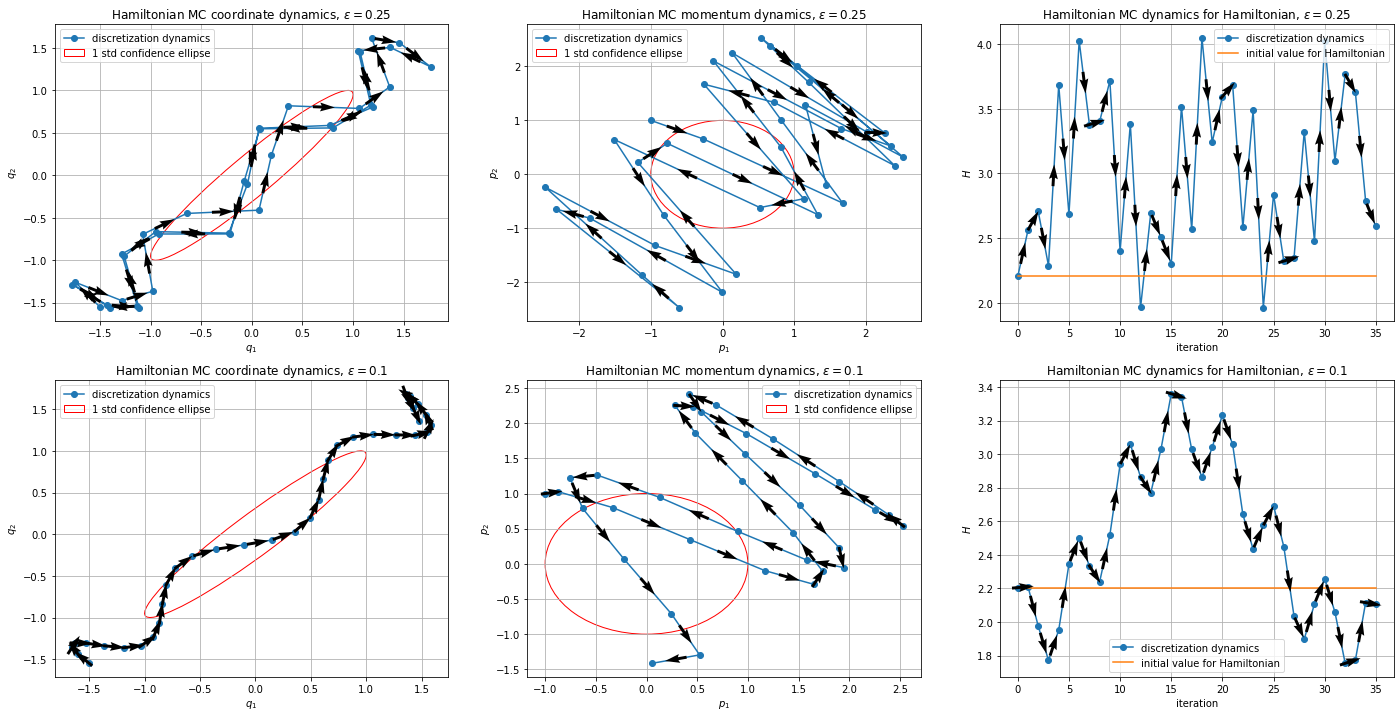

In [8]:
figsize = (24, 12)
fig = plt.figure(figsize = figsize)
epsilons = [0.25, 0.1]
num_epsilons = len(epsilons)
for i, epsilon in enumerate(epsilons):
    q_result, q_dynamics, p_dynamics = Hamiltonian_MC_dynamics_step(U_quadratic_2d, 
                                                                grad_U, 
                                                                epsilon, 
                                                                warmup_steps, 
                                                                q0_2d,
                                                                p0_2d,
                                                                device,
                                                                True,
                                                                Sigma_inv)
    q_dynamics_plot, p_dynamics_plot = (q_dynamics.detach().cpu().numpy(), 
                                                p_dynamics.detach().cpu().numpy())
    H_dynamics_plot = np.array([U_quadratic_2d(torch.tensor(q_dynamics_plot[i, :], 
                                              dtype = torch.float64), 
                                              Sigma_inv.cpu()) + \
                (p_dynamics_plot[i, :] @ p_dynamics_plot[i, :])/2 for i in range(q_dynamics_plot.shape[0])])

    q_u = np.diff(q_dynamics_plot[:, 0])
    q_v = np.diff(q_dynamics_plot[:, 1])
    pos_q_1 = q_dynamics_plot[:-1, 0] + q_u/2
    pos_q_2 = q_dynamics_plot[:-1, 1] + q_v/2
    q_norm = np.sqrt(q_u**2+q_v**2) 

    cur_plot = plt.subplot(num_epsilons, 3, 1 + 3*i)
    cur_plot.set_xlabel(r'$q_1$')
    cur_plot.set_ylabel(r'$q_2$')
    cov_ellipse = plot_cov_ellipse(cov = Sigma.cpu().numpy(),
                                   label = '1 std confidence ellipse',
                                   pos = [0, 0], nstd = 1)
    cur_plot.add_patch(cov_ellipse)
    cur_plot.plot(q_dynamics_plot[:, 0], q_dynamics_plot[:, 1], label = 'discretization dynamics', marker="o")
    cur_plot.quiver(pos_q_1, pos_q_2, q_u/q_norm, q_v/q_norm, angles="xy", zorder=5, pivot="mid")
    cur_plot.set_title(fr"Hamiltonian MC coordinate dynamics, $\varepsilon = {epsilon}$")
    cur_plot.grid(True)
    cur_plot.legend()

    p_u = np.diff(p_dynamics_plot[:, 0])
    p_v = np.diff(p_dynamics_plot[:, 1])
    pos_p_1 = p_dynamics_plot[:-1, 0] + p_u/2
    pos_p_2 = p_dynamics_plot[:-1, 1] + p_v/2
    p_norm = np.sqrt(p_u**2+p_v**2) 

    cur_plot = plt.subplot(num_epsilons, 3, 2 + 3*i)
    cur_plot.set_xlabel(r'$p_1$')
    cur_plot.set_ylabel(r'$p_2$')
    cur_plot.plot(p_dynamics_plot[:, 0], p_dynamics_plot[:, 1], label = 'discretization dynamics', marker="o")
    cur_plot.quiver(pos_p_1, pos_p_2, p_u/p_norm, p_v/p_norm, angles="xy", zorder=5, pivot="mid")
    cur_plot.set_title(fr"Hamiltonian MC momentum dynamics, $\varepsilon = {epsilon}$")
    circle = plt.Circle((0, 0), 1, color = 'r', fill = False, label = '1 std confidence ellipse')           
    cur_plot.add_patch(circle)
    cur_plot.grid(True)
    cur_plot.legend()

    iterations_arr = np.arange(q_dynamics_plot.shape[0])
    H_u = np.diff(iterations_arr)
    H_v = np.diff(H_dynamics_plot)
    pos_H_1 = iterations_arr[:-1] + H_u/2
    pos_H_2 = H_dynamics_plot[:-1] + H_v/2
    H_norm = np.sqrt(H_u**2+H_v**2) 

    cur_plot = plt.subplot(num_epsilons, 3, 3 + 3*i)
    cur_plot.set_xlabel('iteration')
    cur_plot.set_ylabel(r'$H$')
    cur_plot.plot(iterations_arr, H_dynamics_plot, label = 'discretization dynamics', marker="o")
    cur_plot.quiver(pos_H_1, pos_H_2, H_u/H_norm, H_v/H_norm, angles="xy", zorder=5, pivot="mid")
    cur_plot.set_title(fr"Hamiltonian MC dynamics for Hamiltonian, $\varepsilon = {epsilon}$")
    cur_plot.grid(True)
    cur_plot.plot([H_dynamics_plot[0] for i in range(H_dynamics_plot.shape[0])], 
                   label = 'initial value for Hamiltonian')
    cur_plot.legend()

fig.savefig("Hamilton_Dynamics_2D.pdf")
plt.show()

## Testing sampling using HMC and Metropolis algorithm 

In [9]:
q0_2d = torch.tensor([-1.50, -1.55], 
                  dtype = torch.float64, 
                  device = device,
                  requires_grad = True)
Sigma = torch.tensor([[1, 0.98], [0.98, 1]], 
                     dtype = torch.float64,
                     device = device)
epsilon = 0.18
warmup_steps = 20
num_iterations = 20
q_dynamics_hmc, num_unique_hmc = Hamiltonian_MC_dynamics(U_quadratic_2d, 
                                                         grad_U, 
                                                         num_iterations,
                                                         epsilon, 
                                                         warmup_steps, 
                                                         q0_2d,
                                                         device,
                                                         False,
                                                         True,
                                                         Sigma_inv)
print(f"Number acceptions in HMC = {num_unique_hmc}, rejection rate = {(1 - num_unique_hmc/num_iterations):.3f}")

Number acceptions in HMC = 15, rejection rate = 0.250


In [10]:
num_iterations = 400
num_steps = 20
cov_proposal = torch.tensor([[epsilon ** 2, 0.], [0., epsilon ** 2]], 
                            dtype = torch.float64,
                            device = device)
target_distribution = MultivariateNormal(loc = torch.zeros(2).to(device),
                                         covariance_matrix = Sigma)
q_dynamics_metropolis, num_unique_metropolis = Metropolis_algo_with_Gaussian_proposal(num_iterations, 
                                                                                      q0_2d, 
                                                                                      cov_proposal, 
                                                                                      target_distribution, 
                                                                                      device = "cuda:0",
                                                                                      return_unique_num = True) 
print(f"Number acceptions in Metropolis algo = {num_unique_metropolis}, \
        rejection rate = {(1 - num_unique_metropolis/num_iterations):.3f}")
q_dynamics_metropolis = q_dynamics_metropolis[::num_steps, :]

Number acceptions in Metropolis algo = 255,         rejection rate = 0.363


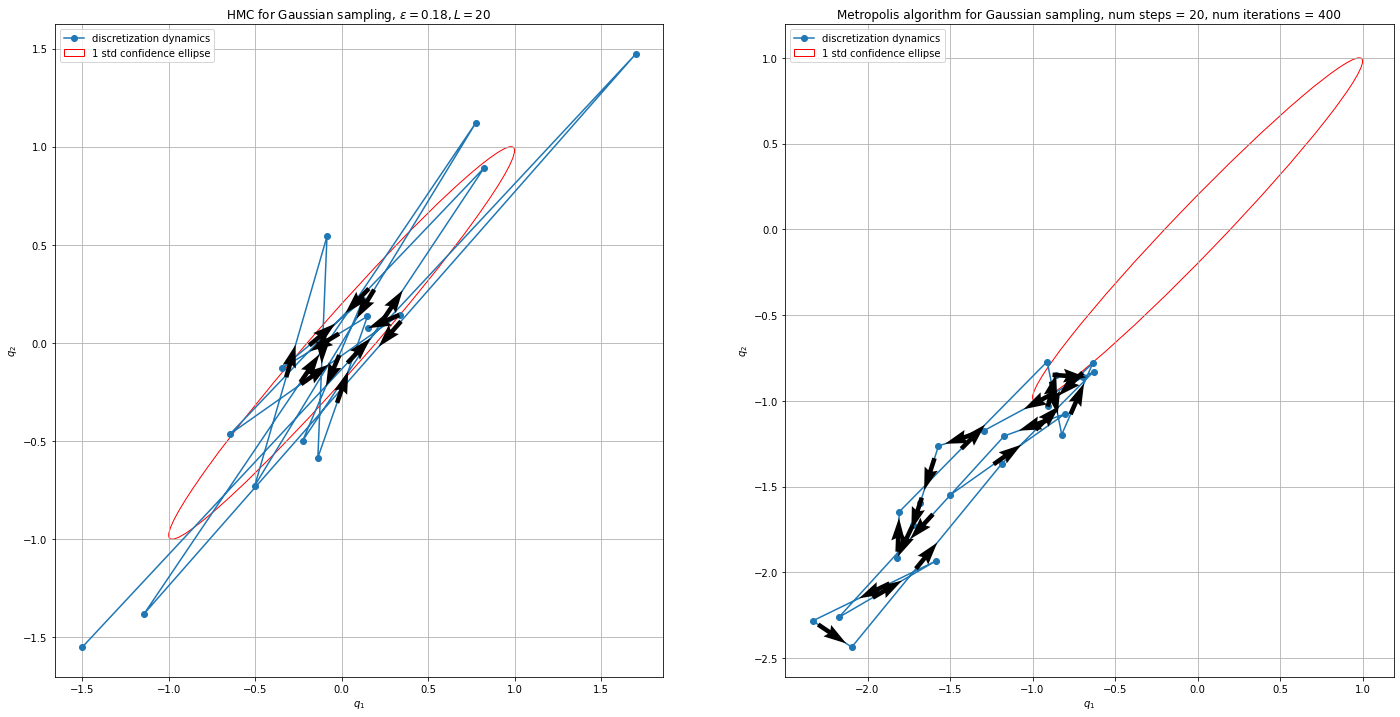

In [11]:
figsize = (24, 12)
fig = plt.figure(figsize = figsize)

q_dynamics_hmc_plot = q_dynamics_hmc.detach().cpu().numpy()
q_hmc_u = np.diff(q_dynamics_hmc_plot[:, 0])
q_hmc_v = np.diff(q_dynamics_hmc_plot[:, 1])
pos_q_1_hmc = q_dynamics_hmc_plot[:-1, 0] + q_hmc_u/2
pos_q_2_hmc = q_dynamics_hmc_plot[:-1, 1] + q_hmc_v/2
q_hmc_norm = np.sqrt(q_hmc_u**2+q_hmc_v**2) 

cur_plot = plt.subplot(1, 2, 1)
cur_plot.set_xlabel(r'$q_1$')
cur_plot.set_ylabel(r'$q_2$')
cov_ellipse = plot_cov_ellipse(cov = Sigma.cpu().numpy(),
                               label = '1 std confidence ellipse',
                               pos = [0, 0], nstd = 1)
cur_plot.add_patch(cov_ellipse)
cur_plot.plot(q_dynamics_hmc_plot[:, 0], q_dynamics_hmc_plot[:, 1], 
              label = 'discretization dynamics', marker="o")
cur_plot.quiver(pos_q_1_hmc, pos_q_2_hmc, q_hmc_u/q_hmc_norm, q_hmc_v/q_hmc_norm, 
                angles="xy", zorder=5, pivot="mid")
cur_plot.set_title(fr"HMC for Gaussian sampling, $\varepsilon = {epsilon}, L = {warmup_steps}$")
cur_plot.grid(True)
cur_plot.legend()

q_dynamics_metropolis_plot = q_dynamics_metropolis.detach().cpu().numpy()
q_metropolis_u = np.diff(q_dynamics_metropolis_plot[:, 0])
q_metropolis_v = np.diff(q_dynamics_metropolis_plot[:, 1])
pos_q_1_metropolis = q_dynamics_metropolis_plot[:-1, 0] + q_metropolis_u/2
pos_q_2_metropolis = q_dynamics_metropolis_plot[:-1, 1] + q_metropolis_v/2
q_metropolis_norm = np.sqrt(q_metropolis_u**2+q_metropolis_v**2) 

cur_plot = plt.subplot(1, 2, 2)
cur_plot.set_xlabel(r'$q_1$')
cur_plot.set_ylabel(r'$q_2$')
cov_ellipse = plot_cov_ellipse(cov = Sigma.cpu().numpy(),
                               label = '1 std confidence ellipse',
                               pos = [0, 0], nstd = 1)
cur_plot.add_patch(cov_ellipse)
cur_plot.plot(q_dynamics_metropolis_plot[:, 0], q_dynamics_metropolis_plot[:, 1], 
              label = 'discretization dynamics', marker="o")
cur_plot.quiver(pos_q_1_metropolis, pos_q_2_metropolis, 
                q_metropolis_u/q_metropolis_norm, 
                q_metropolis_v/q_metropolis_norm, 
                angles="xy", zorder=5, pivot="mid")
title = f"Metropolis algorithm for Gaussian sampling, num steps = {num_steps}, num iterations = {num_iterations}"
cur_plot.set_title(title)
cur_plot.grid(True)
cur_plot.legend()

fig.savefig("Metropolis_and_HMC_2D.pdf")
plt.show()

## Plotting changing of coordinate during iterations

In [19]:
q0_2d = torch.tensor([-1.50, -1.55], 
                  dtype = torch.float64, 
                  device = device,
                  requires_grad = True)
Sigma = torch.tensor([[1, 0.98], [0.98, 1]], 
                     dtype = torch.float64,
                     device = device)
Sigma_inv = torch.inverse(Sigma)

epsilon = 0.18
warmup_steps = 20
num_iterations = 200
q_dynamics_hmc, num_unique_hmc = Hamiltonian_MC_dynamics(U_quadratic_2d, 
                                                         grad_U, 
                                                         num_iterations,
                                                         epsilon, 
                                                         warmup_steps, 
                                                         q0_2d,
                                                         device,
                                                         True,
                                                         True,
                                                         Sigma_inv)
print(f"Number acceptions in HMC = {num_unique_hmc}, rejection rate = {(1 - num_unique_hmc/num_iterations):.3f}")

Number acceptions in HMC = 120, rejection rate = 0.400


In [20]:
num_iterations = 200*20
num_steps = 20
cov_proposal = torch.tensor([[epsilon ** 2, 0.], [0., epsilon ** 2]], 
                            dtype = torch.float64,
                            device = device)
target_distribution = MultivariateNormal(loc = torch.zeros(2).to(device),
                                         covariance_matrix = Sigma)
q_dynamics_metropolis, num_unique_metropolis = Metropolis_algo_with_Gaussian_proposal(num_iterations, 
                                                                                      q0_2d, 
                                                                                      cov_proposal, 
                                                                                      target_distribution, 
                                                                                      device = "cuda:0",
                                                                                      return_unique_num = True) 
print(f"Number acceptions in Metropolis algo = {num_unique_metropolis}, \
        rejection rate = {(1 - num_unique_metropolis/num_iterations):.3f}")
q_dynamics_metropolis = q_dynamics_metropolis[::num_steps, :]

Number acceptions in Metropolis algo = 2545,         rejection rate = 0.364


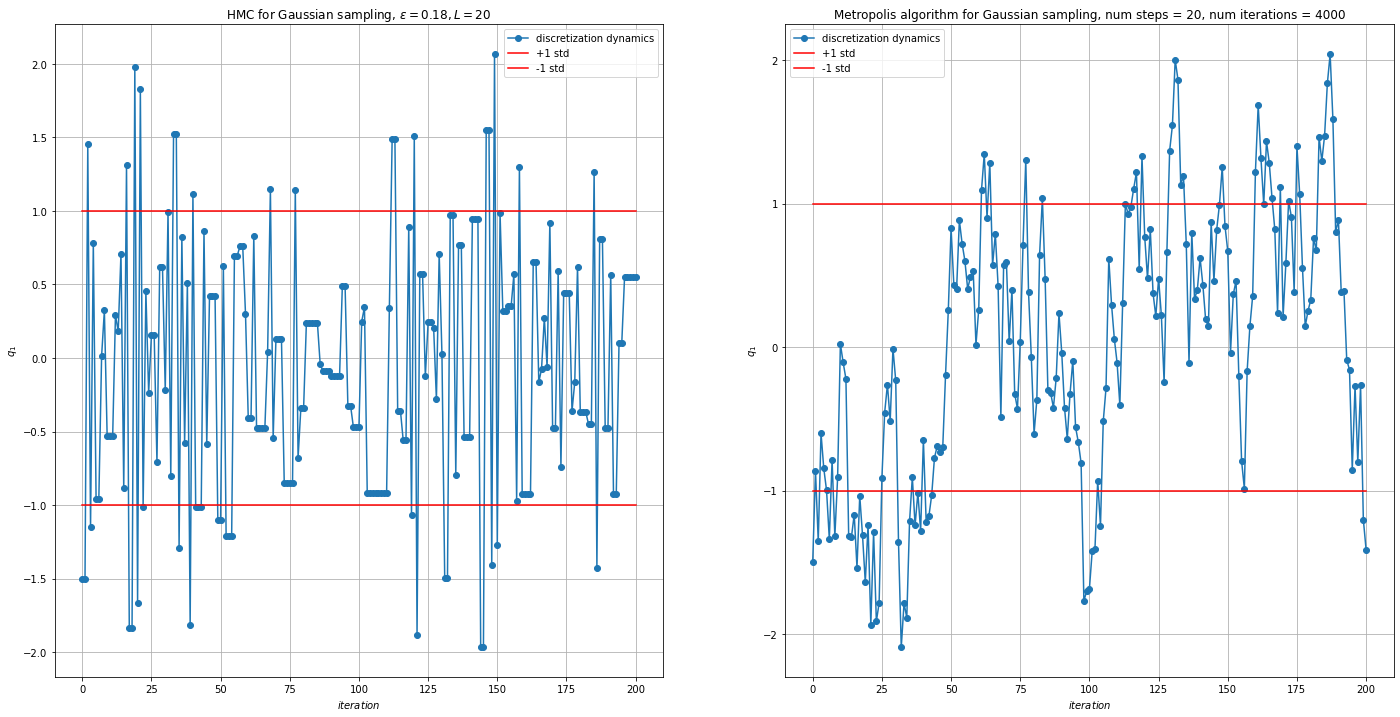

In [21]:
figsize = (24, 12)
fig = plt.figure(figsize = figsize)

q_dynamics_hmc_plot = q_dynamics_hmc.detach().cpu().numpy()
steps_arr = np.arange(len(q_dynamics_hmc_plot))

cur_plot = plt.subplot(1, 2, 1)
cur_plot.set_xlabel(r'$iteration$')
cur_plot.set_ylabel(r'$q_1$')
cur_plot.plot(steps_arr, q_dynamics_hmc_plot[:, 0], 
              label = 'discretization dynamics', marker="o")
cur_plot.plot([torch.sqrt(Sigma[0, 0]) for i in steps_arr], 
                   label = '+1 std', color = 'r')
cur_plot.plot([-torch.sqrt(Sigma[0, 0]) for i in steps_arr], 
                   label = '-1 std', color = 'r')
cur_plot.set_title(fr"HMC for Gaussian sampling, $\varepsilon = {epsilon}, L = {warmup_steps}$")
cur_plot.grid(True)
cur_plot.legend()

q_dynamics_metropolis_plot = q_dynamics_metropolis.detach().cpu().numpy()
steps_arr = np.arange(len(q_dynamics_metropolis_plot))

cur_plot = plt.subplot(1, 2, 2)
cur_plot.set_xlabel(r'$iteration$')
cur_plot.set_ylabel(r'$q_1$')
cur_plot.plot(steps_arr, q_dynamics_metropolis_plot[:, 0], 
              label = 'discretization dynamics', marker="o")
cur_plot.plot([torch.sqrt(Sigma[0, 0]) for i in steps_arr], 
                   label = '+1 std', color = 'r')
cur_plot.plot([-torch.sqrt(Sigma[0, 0]) for i in steps_arr], 
                   label = '-1 std', color = 'r')
cur_plot.grid(True)
cur_plot.legend()
title = f"Metropolis algorithm for Gaussian sampling, num steps = {num_steps}, num iterations = {num_iterations}"
cur_plot.set_title(title)

fig.savefig("HMC_2D_last_coordinate.pdf")   
plt.show()

## Sampling from 100-dimensional distribution

In [199]:
dim = 100
stds = torch.linspace(start = 0.01, 
                      end = 1.0, 
                      steps = dim,
                      dtype = torch.float64).to(device)
var = stds ** 2
Sigma = torch.diag(var)
Sigma_inv = torch.inverse(Sigma)
q0_100d = torch.zeros(dim, 
                      dtype = torch.float64, 
                      requires_grad = True).to(device)

warmup_steps = 150
num_iterations = 1000
low_epsilon = 0.0104
high_epsilon = 0.0156

q_dynamics_hmc, num_unique_hmc = Hamiltonian_MC_dynamics_uniform_epsilon(U_quadratic_2d, 
                                                                         grad_U, 
                                                                         num_iterations,
                                                                         low_epsilon, 
                                                                         high_epsilon,
                                                                         warmup_steps, 
                                                                         q0_100d,
                                                                         device,
                                                                         True,
                                                                         True,
                                                                         Sigma_inv)
print(f"Number acceptions in HMC = {num_unique_hmc}, rejection rate = {(1 - num_unique_hmc/num_iterations):.3f}")

Number acceptions in HMC = 472, rejection rate = 0.528


In [200]:
num_iterations = 150*1000
num_steps = 150
target_distribution = MultivariateNormal(loc = torch.zeros(dim).to(device),
                                         covariance_matrix = Sigma)
low_std = 0.0176
high_std = 0.0264

(q_dynamics_metropolis, 
 num_unique_metropolis) = Metropolis_algo_with_Gaussian_proposal_uniform_stds(num_iterations, 
                                                                              q0_100d, 
                                                                              low_std,
                                                                              high_std, 
                                                                              target_distribution, 
                                                                              device,
                                                                              True) 
print(f"Number acceptions in Metropolis algo = {num_unique_metropolis}, \
        rejection rate = {(1 - num_unique_metropolis/num_iterations):.3f}")

Number acceptions in Metropolis algo = 37396,         rejection rate = 0.751


In [201]:
q_dynamics_metropolis_slice = q_dynamics_metropolis[::num_steps, :]

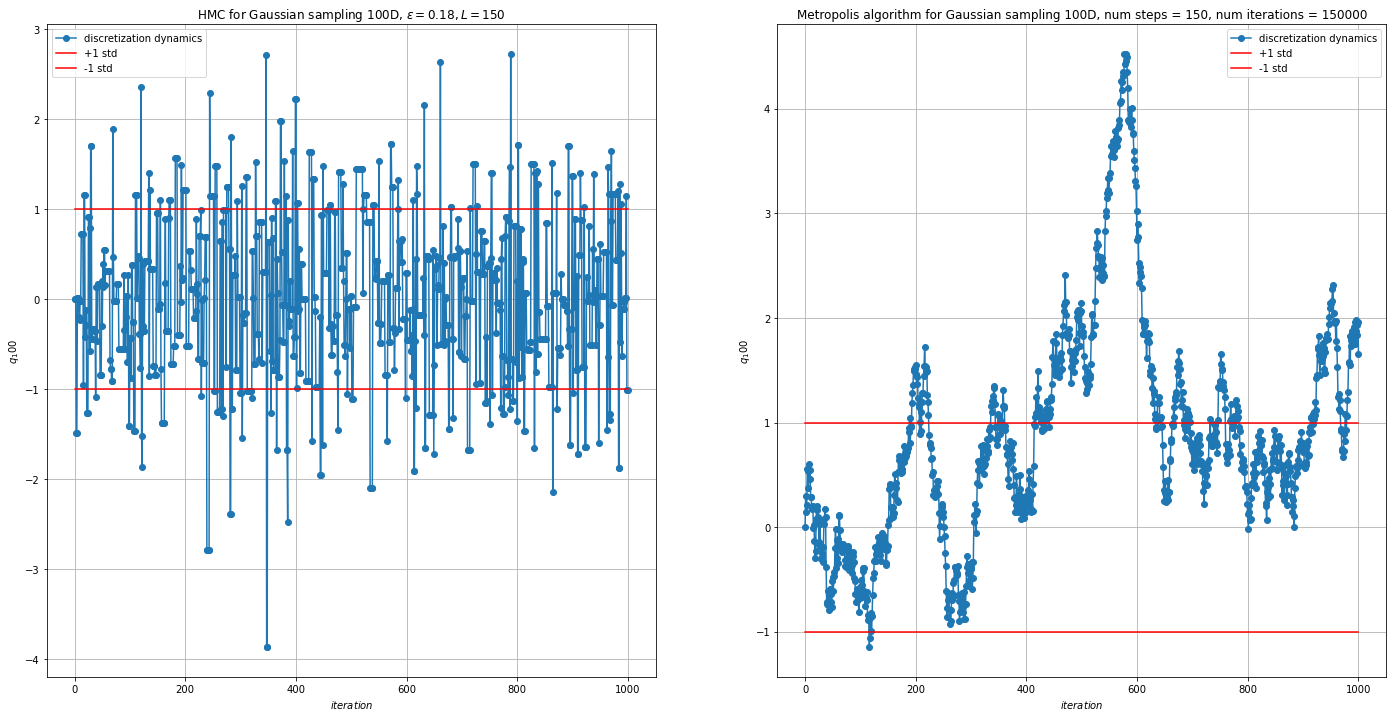

In [206]:
figsize = (24, 12)
fig = plt.figure(figsize = figsize)

q_dynamics_hmc_plot = q_dynamics_hmc.detach().cpu().numpy()
steps_arr = np.arange(len(q_dynamics_hmc_plot))

cur_plot = plt.subplot(1, 2, 1)
cur_plot.set_xlabel(r'$iteration$')
cur_plot.set_ylabel(fr'$q_{100}$')
cur_plot.plot(steps_arr, q_dynamics_hmc_plot[:, -1], 
              label = 'discretization dynamics', marker="o")
cur_plot.plot([torch.sqrt(Sigma[dim - 1, dim - 1]) for i in steps_arr], 
                   label = '+1 std', color = 'r')
cur_plot.plot([-torch.sqrt(Sigma[dim - 1, dim - 1]) for i in steps_arr], 
                   label = '-1 std', color = 'r')
cur_plot.set_title(fr"HMC for Gaussian sampling 100D, $\varepsilon = {epsilon}, L = {warmup_steps}$")
cur_plot.grid(True)
cur_plot.legend()

q_dynamics_metropolis_plot = q_dynamics_metropolis_slice.detach().cpu().numpy()
steps_arr = np.arange(len(q_dynamics_metropolis_plot))

cur_plot = plt.subplot(1, 2, 2)
cur_plot.set_xlabel(r'$iteration$')
cur_plot.set_ylabel(fr'$q_{100}$')
cur_plot.plot(steps_arr, q_dynamics_metropolis_plot[:, -1], 
              label = 'discretization dynamics', marker="o")
cur_plot.plot([torch.sqrt(Sigma[dim - 1, dim - 1]) for i in steps_arr], 
                   label = '+1 std', color = 'r')
cur_plot.plot([-torch.sqrt(Sigma[dim - 1, dim - 1]) for i in steps_arr], 
                   label = '-1 std', color = 'r')
cur_plot.grid(True)
cur_plot.legend()
title = f"Metropolis algorithm for Gaussian sampling 100D, num steps = {num_steps}, num iterations = {num_iterations}"
cur_plot.set_title(title)

fig.savefig("HMC_100D_last_coordinate.pdf")   
plt.show()

In [203]:
hmc_coordinates_mean = torch.mean(q_dynamics_hmc, axis = 0).detach().cpu().numpy()
hmc_coordinates_std = torch.std(q_dynamics_hmc, axis = 0).detach().cpu().numpy()
metropolis_coordinates_mean = torch.mean(q_dynamics_metropolis_slice, axis = 0).detach().cpu().numpy()
metropolis_coordinates_std = torch.std(q_dynamics_metropolis_slice, axis = 0).detach().cpu().numpy()

all_values = np.array([[metropolis_coordinates_mean, hmc_coordinates_mean], 
                       [metropolis_coordinates_std, hmc_coordinates_std]])

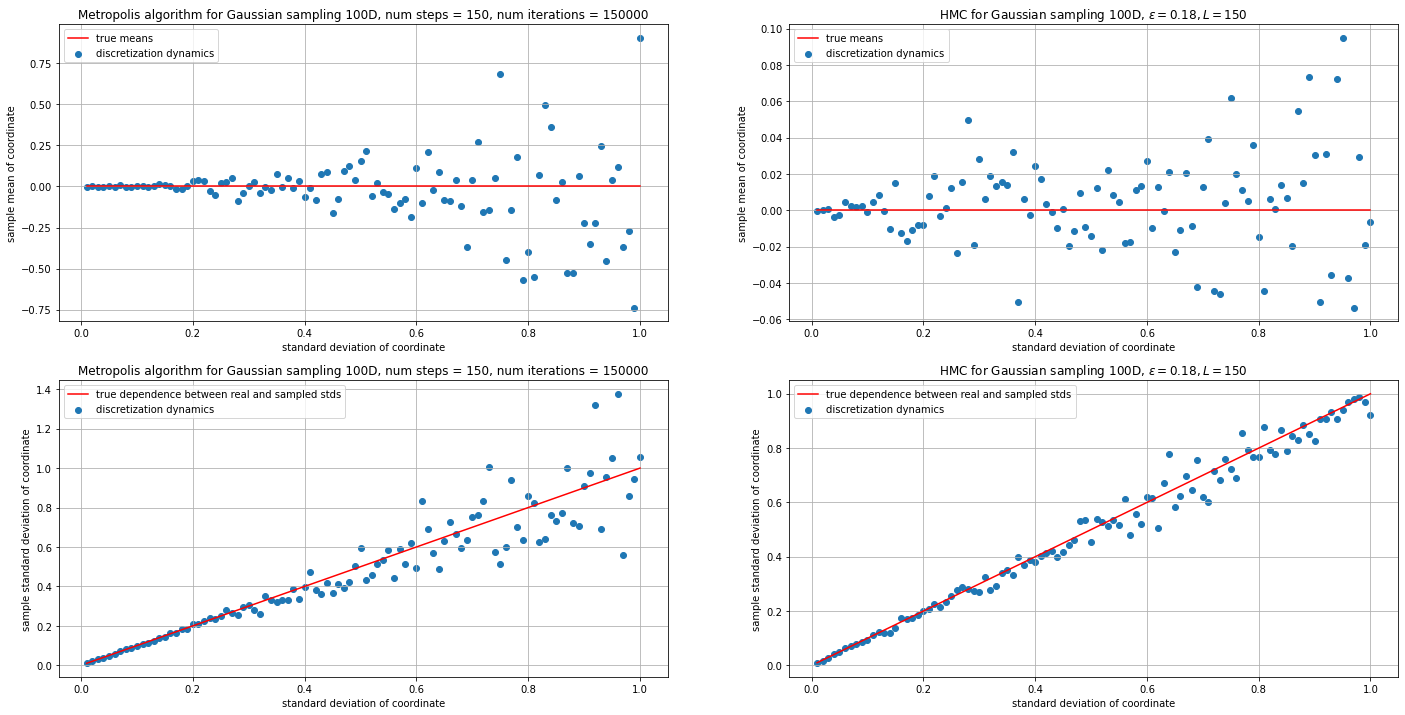

In [205]:
figsize = (24, 12)
fig = plt.figure(figsize = figsize)

for i in range(2):
    for j in range(2):
        cur_plot = plt.subplot(2, 2, 1 + 2*i + j)
        cur_plot.set_xlabel(r'standard deviation of coordinate')
        if i == 0:
            ylabel = 'sample mean of coordinate'
            cur_plot.plot(stds.detach().cpu(), [0 for i in range(len(stds.detach().cpu()))],
                          label = 'true means',
                          color = 'r')
        else:
            ylabel = 'sample standard deviation of coordinate'
            cur_plot.plot(stds.detach().cpu(), stds.detach().cpu(), 
                          label = 'true dependence between real and sampled stds',
                          color = 'r')
            
        if j == 0:
            title = f"Metropolis algorithm for Gaussian sampling 100D, num steps = {num_steps}, num iterations = {num_iterations}"
        else:
            title = fr"HMC for Gaussian sampling 100D, $\varepsilon = {epsilon}, L = {warmup_steps}$"
        cur_plot.set_ylabel(ylabel)
        cur_plot.scatter(stds.detach().cpu(), all_values[i][j], label = 'discretization dynamics', marker="o")
        cur_plot.set_title(title)
        cur_plot.grid(True)
        cur_plot.legend()
fig.savefig("HMC_100D_stds.pdf")   
plt.show()